In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from scipy.sparse import find
import matplotlib.pyplot as plt


def translate_patterns(pats):
    
    rpats = []
    for p in pats:
        if re.search('\{([0-9])+\}', p):
            ps = p.split()
            n = re.search('\{([0-9])+\}', p).group(1)
            p = "(" + ps[0] + " *(\w+\s*\W*){0,"+n+"} " + ps[2] + ")|(" + ps[2] + " *(\w+\s*\W*){0,"+n+"} " + ps[0] + ")"
        else:
            p = p.replace(" ","( |-)")
        rpats.append(p)


    rpat = "|".join(rpats)

    #" OR ".join([x.replace('\w*','*').replace('(\w+\s*\W*){','NEAR/').replace('}','') for x in pats])
    opats = [x.replace('\w*','*') for x in pats if '(\w+\s*\W*){' not in x]
    opats = " OR ".join([f'"{x}"' for x in opats])
    npats = [x.replace('\w*','*').replace('(\w+\s*\W*){','NEAR/').replace('}',' ') for x in pats if '(\w+\s*\W*){' in x]
    npats = " OR ".join([f'"{x}"' for x in npats])
    
    if npats:
        wpat = f'TS=({opats}) OR TS=({npats})'
    else:
        wpat = f'TS=({opats})'
    
    return rpat, wpat

def match_docs(rpat, docs, fields):
    mdocs = set([])
    for f in fields:
        tdocs = set(docs.filter(**{f"{f}__iregex": rpat}).values_list('pk',flat=True))
        mdocs = mdocs | tdocs
        
    nmdocs = docs.exclude(id__in=mdocs)
    mdocs = docs.filter(id__in=mdocs)
    return mdocs, nmdocs

def mash_texts(x, pat=None):
    s = ""
    for at in ["de", "kwp","ab", "ti",]:
        if hasattr(x.wosarticle, at) and getattr(x.wosarticle, at):
            t = getattr(x.wosarticle, at)
            if pat:
                t = re.sub(pat, "", t)
            s+=f" {t}"
    return s.strip()


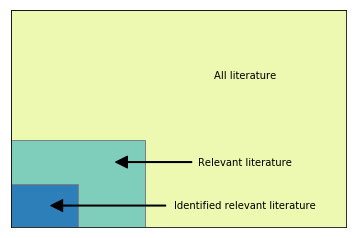

In [55]:
from matplotlib.patches import Rectangle

def lit_plot():
    fig, ax = plt.subplots()
    cols = ['#edf8b1','#7fcdbb','#2c7fb8']
    rect = Rectangle(
        (0,0),1,1, 
        facecolor=cols[0],
        edgecolor="grey"
    )
    ax.add_patch(rect)

    ax.annotate(
        "All literature",
        (0.7,0.7),
        ha="center", va="center",
        #arrowprops=dict(facecolor='black', shrink=0.05,width=1),
    )

    rect = Rectangle(
        (0,0),.4,.4, 
        facecolor=cols[1],
        edgecolor="grey"
    )
    ax.add_patch(rect)

    ax.annotate(
        "Relevant literature",
        (0.3,0.3),(0.7,0.3),
        ha="center", va="center",
        arrowprops=dict(facecolor='black', shrink=0.05,width=1),
    )

    rect = Rectangle(
        (0,0),.2,.2,
        facecolor=cols[2],
        edgecolor="grey"
    )
    ax.add_patch(rect)

    ax.annotate(
        "Identified relevant literature",
        (0.1,0.1),(0.7,0.1),
        ha="center", va="center",
        arrowprops=dict(facecolor='black', shrink=0.05,width=1),
    )

    #ax.axis('off')

    ax.set_xticks([])
    ax.set_yticks([])
    return ax

lit_plot()
plt.savefig("../plots/basic_lit_plot.png")

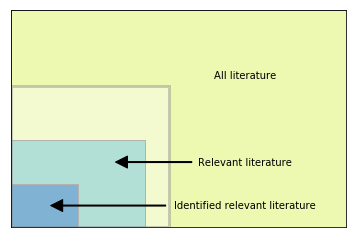

In [74]:
ax = lit_plot()

rect = Rectangle(
    (0,0),.472,.65,
    facecolor="white",
    edgecolor="grey",
    linewidth=3,
    alpha=0.4,
)
ax.add_patch(rect)

plt.savefig("../plots/lit_plot_query_1.png")

plt.show()

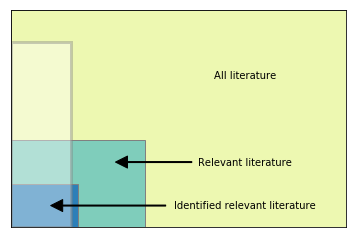

In [75]:
ax = lit_plot()

rect = Rectangle(
    (0,0),.18,.85,
    facecolor="white",
    edgecolor="grey",
    linewidth=3,
    alpha=0.4,
)
ax.add_patch(rect)

plt.savefig("../plots/lit_plot_query_2.png")

plt.show()

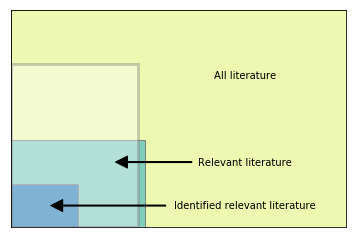

In [76]:
ax = lit_plot()

rect = Rectangle(
    (0,0),.38,.75,
    facecolor="white",
    edgecolor="grey",
    linewidth=3,
    alpha=0.4,
)
ax.add_patch(rect)

plt.savefig("../plots/lit_plot_query_3.png")

plt.show()

In [2]:
docs = Doc.objects.filter(query=6956, content__iregex="\w").order_by('id')

## WHY IS OLIVEIRA, 2007 included?
### Also, Nepstad and Stickler, 2008
### Polidoro 2010, very weak - not main conclusion

# Exclude non-climate docs
docs = docs.exclude(pk__in=[
    
    # ENSO
    1461495, # Espinoza 2013
    1626875, # White, 2007
    
    1622783, # Why is Oliveira, 2007 included?
    1627593, # Killeen 2008
    1627701, # Also, Nepstad and Stickler, 2008
    2093363, # Etter
    2090005, # Nepstad, 2006
    1627734, # Polidoro 2010
    
    2089982, # Mars, 2007
    
    2090013, # Randolph 2010
    
    2093360, # Petney 2012
    
    2089960, # Wassenaar, 2007 - LUC
    1627733, # Polidoro 2010, very weak - not main conclusion
    2090004, # Veran 2007 - long line fishing
    2089967, # Giri - mangrove database, climate only mentioned in conclusion and with reference
    2089944, # Jellyman - eels
    2091676, # Novelo-Casanova, 2010: Cayman Islands climate??
    2089959, # Bruno, 2007 
    1514856, # de Waroux 2012
    2091680, # Guzman, 2008, we consider the main anthropogenic threats to the coral reefs and communities of the islands are overfishing, sedimentation and tourism
    2089950, # Razumov - permafrost and erosion - climate? is the ref there as counter-evidence Nevertheless, the longterm average annual rate
#                             of erosion of the coast line of the bottom of the Arctic
#                             Seas is much lower than in the seas outside the cry
#                             olithozone even under the conditions of the climate’s
#                             warming accompanied by the activation of thermo
#                             abrasion and during the subaqual abrasion processes
#                             (Fig. 5). In particular, this proves the development of
#                             ordinary abrasionaccumulation processes in the Arc
#                             tic Seas, and, here, we cannot say about the influence
#                             of thermal slumps on the formation of the underwater
#                             slope relief
])

#


docs.count()

257

In [3]:
#X = vec.fit_transform(docs.values_list('content',flat=True))

vec = CountVectorizer(
    ngram_range=(1,2),
    min_df=10, strip_accents='unicode', 
    max_features=10000,
    tokenizer=snowball_stemmer()
)


texts = [mash_texts(x) for x in docs]
X = X = vec.fit_transform(texts)
vocab = vec.get_feature_names()
X[X.nonzero()] = 1
X
    


<257x950 sparse matrix of type '<class 'numpy.int64'>'
	with 26903 stored elements in Compressed Sparse Row format>

## Only Climate keywords

## Still unresolved:

- La Nina, El Nino

In [4]:
pats = [
    "climate model",
    "elevated\w* temperatur",
    "ocean\w* warming",
    "saline\w* intrusion",
    "chang\w* climat",
    "environment\w* change",
    "climat\w* change",
    "climat\w* warm",
    "warming\w* climat",
    "climat\w* varia",
    "global\w* warming",
    "global\w* change",
    "greenhouse\w* effect",
    "anthropogen\w*",
    "sea\w* level",
    "precipitation variabil\w*",
    "precipitation change\w*",
    "temperature\w* impact",
    "environmental\w* variab",
    "change\w* (\w+\s*\W*){5} cryosphere",
    "increase\w* (\w+\s*\W*){3} temperatur*",
    "weather\w* pattern",
    "weather\w* factor\w*",
    "climat\w*"
]

crpat, cwpat = translate_patterns(pats)
mdocs, nmdocs = match_docs(crpat, docs, ["wosarticle__de","wosarticle__kwp","title","content"])

ctrpat, ctwpat = translate_patterns(["climat\w*"])
cmdocs, cnmdocs = match_docs(ctrpat, docs, ["title"])
cids = cmdocs.values_list('pk',flat=True)

mids = set(mdocs.values_list('pk',flat=True)) | set(cmdocs.values_list('pk', flat=True))

mdocs = docs.filter(pk__in=mids)
nmdocs = docs.exclude(pk__in=mids)


print(cwpat)

print(f"starting point: {docs.count()} docs")

print(mdocs.count())

for d in nmdocs[:10]:
    print('\n#####')
    print(d.id, d.title)
    print(d.docauthinst_set.all().order_by('position'))
    print(d.PY)
    print(d.content)
    print(d.wosarticle.de)
    print(d.wosarticle.kwp)

TS=("climate model" OR "elevated* temperatur" OR "ocean* warming" OR "saline* intrusion" OR "chang* climat" OR "environment* change" OR "climat* change" OR "climat* warm" OR "warming* climat" OR "climat* varia" OR "global* warming" OR "global* change" OR "greenhouse* effect" OR "anthropogen*" OR "sea* level" OR "precipitation variabil*" OR "precipitation change*" OR "temperature* impact" OR "environmental* variab" OR "weather* pattern" OR "weather* factor*" OR "climat*") OR TS=("change* NEAR/5  cryosphere" OR "increase* NEAR/3  temperatur*")
starting point: 257 docs
256

#####
2089985 RAPID POPULATION INCREASES IN NATIVE VASCULAR PLANTS IN THE ARGENTINE ISLANDS, ANTARCTIC PENINSULA
<QuerySet [<DocAuthInst: FOWBERT, JA>, <DocAuthInst: SMITH, RIL>]>
1994
The number of individual plants and colonies of the two native Antarctic vascular plants, Colobanthus quitensis and Deschampsia antarctica, have been monitored between 1964 and 1990 on three islands in the Argentine Islands archipelago, 

In [5]:
for p in pats:
    trpat, twpat = translate_patterns([x for x in pats if x!=p])
    mdocs, nmdocs = match_docs(trpat, docs, ["wosarticle__de","wosarticle__kwp","title","content"])
    nmdocs = nmdocs.exclude(pk__in=cids.values_list('pk',flat=True))
    print(p)
    print(f'removing "{p}" loses {nmdocs.count()} documents')

climate model
removing "climate model" loses 1 documents
elevated\w* temperatur
removing "elevated\w* temperatur" loses 1 documents
ocean\w* warming
removing "ocean\w* warming" loses 2 documents
saline\w* intrusion
removing "saline\w* intrusion" loses 2 documents
chang\w* climat
removing "chang\w* climat" loses 1 documents
environment\w* change
removing "environment\w* change" loses 2 documents
climat\w* change
removing "climat\w* change" loses 1 documents
climat\w* warm
removing "climat\w* warm" loses 1 documents
warming\w* climat
removing "warming\w* climat" loses 1 documents
climat\w* varia
removing "climat\w* varia" loses 1 documents
global\w* warming
removing "global\w* warming" loses 1 documents
global\w* change
removing "global\w* change" loses 1 documents
greenhouse\w* effect
removing "greenhouse\w* effect" loses 1 documents
anthropogen\w*
removing "anthropogen\w*" loses 3 documents
sea\w* level
removing "sea\w* level" loses 8 documents
precipitation variabil\w*
removing "preci

In [6]:
vec = CountVectorizer(
    ngram_range=(1,2),
    min_df=5, strip_accents='unicode', 
    max_features=10000,
    stop_words=stoplist,
    tokenizer=snowball_stemmer()
)


texts = [mash_texts(x, crpat) for x in docs]
X = X = vec.fit_transform(texts)
vocab = vec.get_feature_names()
X[X.nonzero()] = 1
X

<257x1367 sparse matrix of type '<class 'numpy.int64'>'
	with 22275 stored elements in Compressed Sparse Row format>

In [7]:
colsum = np.array(X.sum(axis=0))[0]

for i in np.argsort(colsum)[-10:]:
    print(vocab[i])
    print(colsum[i])

show
103
trend
104
studi
106
use
107
year
112
impact
112
temperatur
118
region
128
increas
152
chang
198


In [8]:
pats = [
    "impact\w*",
    "specie\w*",
    "mortality\w*",
    "ecosystem\w*",
    #"snowmelt\w*",
    "mass balance",
    #"landslide\w*",
    "flood\w*",
    "drought",
    "disease\w*",
    #"desertification",
    "glacier\w* (\w+\s*\W*){3} melt\w*",
    "glacier\w* (\w+\s*\W*){3} mass\w*",
    "adaptation",
    "malaria",
    #"population dynamic",
    "fire",
    #"coral bleaching",
    "water scarcity",
    "water supply",
    #"yield response\w*",
    "erosion\w* (\w+\s*\W*){5} coast\w*",
    "glacier\w* (\w+\s*\W*){5} retreat\w*",
    #"rainfall\w* (\w+\s*\W*){5} decline\w*",
    "rainfall\w* (\w+\s*\W*){5} reduc\w*",
    "coral\w* (\w+\s*\W*){5} stress\w*",
    #"coral\w* (\w+\s*\W*){5} declin\w*",
    "precip\w* (\w+\s*\W*){5} \w*crease\w*",
    "permafrost",
    "biological response",
    "food availability",
    "food security",
    "vegetation dynamic\w*",
    "river (\w+\s*\W*){5} flow",
    "cyclone\w*",
    "yield\w*",
    #"deglacier\w*",
    "snow water equival\w*",
    "surface temp\w*"
]

irpat, iwpat = translate_patterns(pats)
mdocs, nmdocs = match_docs(irpat, docs, ["wosarticle__de","wosarticle__kwp","title","content"])

print(iwpat)

print(f"starting point: {docs.count()} docs")

print(mdocs.count())

#for d in random.sample(list(nmdocs), 10):
for d in nmdocs[:10]:
    print('\n#####')
    print(d.id, d.title)
    print(d.docauthinst_set.all().order_by('position'))
    print(d.PY)
    print(d.content)
    print(d.wosarticle.de)
    print(d.wosarticle.kwp)


TS=("impact*" OR "specie*" OR "mortality*" OR "ecosystem*" OR "mass balance" OR "flood*" OR "drought" OR "disease*" OR "adaptation" OR "malaria" OR "fire" OR "water scarcity" OR "water supply" OR "permafrost" OR "biological response" OR "food availability" OR "food security" OR "vegetation dynamic*" OR "cyclone*" OR "yield*" OR "snow water equival*" OR "surface temp*") OR TS=("glacier* NEAR/3  melt*" OR "glacier* NEAR/3  mass*" OR "erosion* NEAR/5  coast*" OR "glacier* NEAR/5  retreat*" OR "rainfall* NEAR/5  reduc*" OR "coral* NEAR/5  stress*" OR "precip* NEAR/5  *crease*" OR "river NEAR/5  flow")
starting point: 257 docs
257


In [9]:
for p in pats:
    trpat, twpat = translate_patterns([x for x in pats if x!=p])
    mdocs, nmdocs = match_docs(trpat, docs, ["wosarticle__de","wosarticle__kwp","title","content"])
    #nmdocs = nmdocs.exclude(pk__in=cnmdocs.values_list('pk',flat=True))
    print(p)
    print(f'removing "{p}" loses {nmdocs.count()} documents')

impact\w*
removing "impact\w*" loses 10 documents
specie\w*
removing "specie\w*" loses 10 documents
mortality\w*
removing "mortality\w*" loses 1 documents
ecosystem\w*
removing "ecosystem\w*" loses 5 documents
mass balance
removing "mass balance" loses 6 documents
flood\w*
removing "flood\w*" loses 5 documents
drought
removing "drought" loses 4 documents
disease\w*
removing "disease\w*" loses 1 documents
glacier\w* (\w+\s*\W*){3} melt\w*
removing "glacier\w* (\w+\s*\W*){3} melt\w*" loses 1 documents
glacier\w* (\w+\s*\W*){3} mass\w*
removing "glacier\w* (\w+\s*\W*){3} mass\w*" loses 2 documents
adaptation
removing "adaptation" loses 4 documents
malaria
removing "malaria" loses 2 documents
fire
removing "fire" loses 3 documents
water scarcity
removing "water scarcity" loses 1 documents
water supply
removing "water supply" loses 1 documents
erosion\w* (\w+\s*\W*){5} coast\w*
removing "erosion\w* (\w+\s*\W*){5} coast\w*" loses 1 documents
glacier\w* (\w+\s*\W*){5} retreat\w*
removing "gla

In [11]:
pats = [
    "recent",
    "current",
    "modern",
    "observ\w*",
    #"case study",
    "evidence\w*",
    "past",
    "local",
    "region\w*",
    "significant",
    "driver\w*",
    "response",
    #"have responded",
    "were responsible",
    "was responsible",
    "exhibited",
    "witnessed",
    "attribut\w*",
    "has increased",
    "has decreased",
    #"have increased",
    #"have decreased",
    "histor\w*",
    #"recorded",
    "correlation",
    "evaluation",
]


arpat, awpat = translate_patterns(pats)
mdocs, nmdocs = match_docs(arpat, docs, ["wosarticle__de","wosarticle__kwp","title","content"])

print(awpat)

print(f"starting point: {docs.count()} docs")

print(mdocs.count())

#for d in random.sample(list(nmdocs), 10):
for d in nmdocs[:10]:
    print('\n#####')
    print(d.id, d.title)
    print(d.docauthinst_set.all().order_by('position'))
    print(d.PY)
    print(d.content)
    print(d.wosarticle.de)
    print(d.wosarticle.kwp)

TS=("recent" OR "current" OR "modern" OR "observ*" OR "evidence*" OR "past" OR "local" OR "region*" OR "significant" OR "driver*" OR "response" OR "were responsible" OR "was responsible" OR "exhibited" OR "witnessed" OR "attribut*" OR "has increased" OR "has decreased" OR "histor*" OR "correlation" OR "evaluation")
starting point: 257 docs
257


### go through each keyword (for all pattern lists), checking what changes if it is removed.

In [13]:

mdocs, nmdocs = match_docs(arpat, docs, ["wosarticle__de","wosarticle__kwp","title","content"])
mdocs.count()

257

In [14]:
for p in pats:
    trpat, twpat = translate_patterns([x for x in pats if x!=p])
    mdocs, nmdocs = match_docs(trpat, docs, ["wosarticle__de","wosarticle__kwp","title","content"])
    if nmdocs.count()==0:
        print(f'removing "{p}" loses {nmdocs.count()} documents')

removing "was responsible" loses 0 documents
removing "has decreased" loses 0 documents


In [ ]:
## All queries together
f"({awpat}) AND ({iwpat}) AND ({cwpat})"


In [19]:
query_docs = Doc.objects.filter(query=7368)

qds = list(query_docs.order_by('id').values("id","wosarticle__de","wosarticle__kwp","wosarticle__ab","wosarticle__ti"))
qds[0]

In [31]:
ids = []
texts = []
subset_ids = []
subset_docs = list(mdocs.values_list('pk',flat=True))



def mash_texts(x, pat=None):
    s = ""
    for at in ["wosarticle__de", "wosarticle__kwp","wosarticle__ab", "wosarticle__ti",]:
        if at in x:
            t = x[at]
            if pat:
                t = re.sub(pat, "", t)
            s+=f" {t}"
    return s.strip()

for i, d in enumerate(qds):
    if i % 100000 == 0:
        print(i)
    ids.append(i)
    texts.append(mash_texts(d))
    if d['id'] in subset_docs:
        subset_ids.append(i)



0
100000
200000
300000


In [34]:
X = X = vec.fit_transform(texts)
vocab = vec.get_feature_names()
X[X.nonzero()] = 1
X

<318385x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 37729988 stored elements in Compressed Sparse Row format>

In [35]:
#subset = X[random.sample(range(X.shape[0]),round(X.shape[0]*0.1))]
subset = X[subset_ids]
subset

<228x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 27598 stored elements in Compressed Sparse Row format>

In [36]:
colsum = np.array(subset.sum(axis=0))[0]
zeros = np.argwhere(colsum==0)[:,0]
print(len(zeros))

4719


In [37]:
X[:,zeros]

<318385x4719 sparse matrix of type '<class 'numpy.int64'>'
	with 5077565 stored elements in Compressed Sparse Row format>

In [43]:
zsums = np.array(X[:,zeros].sum(axis=0))
zsorted =  np.argsort(zsums)[0]
for i in zsorted[-200:][::-1]:
    z = int(zeros[i])
    v = vocab[z]
    n = zsums[0][i]
    print(v, n)
    

captur 10627
isol 10077
fossil 9402
author 9226
american 8877
acid 8610
pleistocen 8591
transfer 8394
goal 8382
oxid 7966
particl 7172
parameter 6973
pollen 6913
receiv 6860
ozon 6707
photosynthesi 6703
cell 6675
share 6485
valuabl 6116
dna 5896
wood 5759
assimil 5723
phylogenet 5721
section 5696
electr 5508
genotyp 5480
particul 5462
fine 5431
iii 5426
classifi 5322
choic 5295
photosynthet 5278
last glacial 5229
cultivar 4995
genet divers 4950
polit 4944
result studi 4797
conceptu 4761
precis 4743
promis 4730
biogeochem 4711
hybrid 4703
studi provid 4680
distribut model 4672
nitrat 4636
protein 4612
modi 4593
accept 4574
spp 4564
optic 4538
downscal 4528
toxic 4480
gcm 4413
resourc manag 4404
system model 4389
glacial maximum 4338
methan 4337
propag 4325
retriev 4317
signatur 4315
intensifi 4190
object studi 4177
relat humid 4130
tradeoff 4129
use effici 4050
use model 4036
chlorophyl 4021
dimens 3969
real 3957
decemb 3928
diversif 3911
signific effect 3907
communic 3876
north america

In [ ]:
# - impact not impact assessment
exclusions = [
    "carbon captur*",
    "life cycle assessment",
    "pleistocen*",
    "fuel cell"
]

In [28]:
for d in mdocs.filter(content__icontains="model").exclude(content__iregex="examin|evidenc|observ|measure").values('content'):
    print(d)
    print()

{'content': 'Recent studies documenting shifts in spatial distribution of many organisms in response to a warming climate highlight the need to understand the mechanisms underlying species distribution at large spatial scales. Here we present one noteworthy example of remote oceanographic processes governing the spatial distribution of adult silver hake, Merluccius bilinearis, a commercially important fish in the Northeast US shelf region. Changes in spatial distribution of silver hake over the last 40 years are highly correlated with the position of the Gulf Stream. These changes in distribution are in direct response to local changes in bottom temperature on the continental shelf that are responding to the same large scale circulation change affecting the Gulf Stream path, namely changes in the Atlantic meridional overturning circulation (AMOC). If the AMOC weakens, as is suggested by global climate models, silver hake distribution will remain in a poleward position, the extent to wh

In [93]:
zeros[205]

598

In [ ]:
texts = [mash_texts(x) for x in mdocs]
X = X = vec.fit_transform(texts)
vocab = vec.get_feature_names()
X[X.nonzero()] = 1

In [ ]:
# Find combinations of vocab (except for those that contain the stopwords below)

indices, vals = np.array(X.sum(0))[0].argsort()[::-1], np.sort(np.array(X.sum(0))[0])[::-1]

all_cs = list(combinations(indices[:300],2))

print(len(all_cs))

c_lengths = []
cs = []
max_x = 0
max_ind = 0
local_stops = set([
    "use","also","studi","may","larg","dure","occur","result",
    "climat chang","year"
]) | set(climate_words)

stop_combos = [
    ["studi","year"],
    ["year","data"],
    ["year","observ"],
    ["year","dure"],
    ["data","indic"],
    ["water","ocean"],
    ["increase", "result"],
    ["sea","ocean"],
    ["chang", "increas"],
    ["increas", "temperatur"],
    ["data", "analysi"],
    ["impact","effect"],
    ["result", "high"],
    ["chang","warm"],
    ["climat","warm"],
    ["climat","temperatur"],
    ["show", "data"]
]

for c in all_cs:
    words = [vocab[x] for x in c]
    if len(local_stops & set(words))>0:
        continue
    if words in stop_combos:
        continue
    if len(set(words) & set(climate_words)) > 0:
        continue
    x = sum([X[:,x] for x in c])
    l = x[x > 1].shape[1]
    c_lengths.append(l)   
    cs.append(c)
    
print(len(cs))

In [ ]:
ids = []

# Go through the combinations, choosing the one that adds the most relevant documents
seen = []
for i in range(25):
    
    if i==0:
        c = cs[np.argsort(c_lengths)[::-1][0]]
        x = sum([X[:,xi] for xi in c])
        x[x==1] = 0
        x.eliminate_zeros()
        x[x>0] = 1
        ids.append(c)
        continue

    base_l = len(x.data)
    max_l = len(x.data)
    max_ind = None
    
    for ind in np.argsort(c_lengths)[::-1]:
        if ind in seen:
            continue
        c = cs[ind]
        words = [vocab[x] for x in c]
        if len(local_stops & set(words))>0:
            continue
        if words in stop_combos:
            continue
        if c in ids:
            continue
        tmp_x = sum([X[:,xi] for xi in c])
        for w in range(1, len(c)):
            tmp_x[tmp_x==w] = 0
        tmp_x.eliminate_zeros()
        tmp_x[tmp_x>0] = 1
        tmp_x = x + tmp_x
        l = len(tmp_x.data)
        if l > max_l:
            max_l = l
            max_ind = ind
        if l <= base_l: 
            seen.append(ind)
            
    if not max_ind:
        break
    else:
        c = cs[max_ind]
        tmp_x = sum([X[:,xi] for xi in c])
        for w in range(1, len(c)):
            tmp_x[tmp_x==w] = 0
        tmp_x.eliminate_zeros()
        tmp_x[tmp_x>0] = 1
        x = x + tmp_x
        x[x>1]=1
        ids.append(c)
        print(f"{i+1}: {max_l}")
        if x.shape[0] == max_l:
            break
                
c = [" AND ".join([vocab[x]+"*" for x in c]) for c in ids]
print(c)
print(max_l)       


In [ ]:
t = " OR ".join([f"({x})" for x in c])
q = f"TS=({t})"
print(q)

In [ ]:
X.shape

In [ ]:
texts[np.where(x.A==0)[0][0]]

In [ ]:
np.where(x.A==0)

for j in list(find(X[353]))[1]:
    print(vocab[j])

In [ ]:
# Climate words

cwords = ["climate change","climat"]
for t in texts:
    tc = False
    for w in cwords:
        if w in t.lower():
            tc=True
    if not tc:
        print(t)
        break


In [ ]:
# for i,c in enumerate(combinations(indices, 4)):
#     x = sum([X[:,x] for x in c])
#     l = len(x.data)
#     if l > 740:
#         print(f'{" OR ".join([vocab[x] for x in c])} returns {l}')

In [ ]:
ids = []
for i in range(10):
    if i==0:
        x = X[:,indices[0]]
        ids.append(indices[0])
        continue
    max_x = len(x.data)
    max_ind = None
    for ind in indices:
        if ind in ids:
            continue
        tmp_x = x + X[:,ind]
        if len(tmp_x.data) > max_x:
            max_x = len(tmp_x.data)
            max_ind = ind
    if not max_ind:
        break
    else:
        x = x + X[:,max_ind]
        ids.append(max_ind)
        print(max_x)
        
print(i)
print(f'{" OR ".join([vocab[x]+"*" for x in ids])} returns {len(x.data)}')

In [ ]:
n_ids = []
for i in range(10):
    if i==0:
        for ind in indices:
            if ind not in ids:
                x = X[:,ind]
                n_ids.append(ind)
                break
        continue
    max_x = len(x.data)
    max_ind = None
    for ind in indices:
        if ind in ids or ind in n_ids:
            continue
        tmp_x = x + X[:,ind]
        if len(tmp_x.data) > max_x:
            max_x = len(tmp_x.data)
            max_ind = ind
    if not max_ind:
        break
    else:
        x = x + X[:,max_ind]
        n_ids.append(max_ind)
        print(max_x)
        
print(i)
strings = [f'"{vocab[x]}*"' for x in n_ids]
print(f'{" OR ".join(strings)} returns {len(x.data)}')

In [ ]:
ids += n_ids
n_ids = []
for i in range(10):
    if i==0:
        for ind in indices:
            if ind not in ids:
                x = X[:,ind]
                n_ids.append(ind)
                break
        continue
    max_x = len(x.data)
    max_ind = None
    for ind in indices:
        if ind in ids or ind in n_ids:
            continue
        tmp_x = x + X[:,ind]
        if len(tmp_x.data) > max_x:
            max_x = len(tmp_x.data)
            max_ind = ind
    if not max_ind:
        break
    else:
        x = x + X[:,max_ind]
        n_ids.append(max_ind)
        print(max_x)
        
print(i)
strings = [f'"{vocab[x]}*"' for x in n_ids]
print(f'{" OR ".join(strings)} returns {len(x.data)}')

In [ ]:
ids += n_ids
n_ids = []
for i in range(10):
    if i==0:
        for ind in indices:
            if ind not in ids:
                x = X[:,ind]
                n_ids.append(ind)
                break
        continue
    max_x = len(x.data)
    max_ind = None
    for ind in indices:
        if ind in ids or ind in n_ids:
            continue
        tmp_x = x + X[:,ind]
        if len(tmp_x.data) > max_x:
            max_x = len(tmp_x.data)
            max_ind = ind
    if not max_ind:
        break
    else:
        x = x + X[:,max_ind]
        n_ids.append(max_ind)
        print(max_x)
        
print(i)
print(f'{" OR ".join([vocab[x] for x in n_ids])} returns {len(x.data)}')

In [ ]:
ids += n_ids
n_ids = []
for i in range(10):
    if i==0:
        for ind in indices:
            if ind not in ids:
                x = X[:,ind]
                n_ids.append(ind)
                break
        continue
    max_x = len(x.data)
    max_ind = None
    for ind in indices:
        if ind in ids or ind in n_ids:
            continue
        tmp_x = x + X[:,ind]
        if len(tmp_x.data) > max_x:
            max_x = len(tmp_x.data)
            max_ind = ind
    if not max_ind:
        break
    else:
        x = x + X[:,max_ind]
        n_ids.append(max_ind)
        print(max_x)
        
print(i)
print(f'{" OR ".join([vocab[x] for x in n_ids])} returns {len(x.data)}')